In [21]:
import os
import json

In [22]:
RESULT_PATH = "/mnt/nas/jinho/GrokkedTransformer/collapse_analysis/results/composition.2000.200.inf-controlled/(5,1)"
MODEL_DIR = "/mnt/nas/jinho/GrokkedTransformer/trained_checkpoints/composition.2000.200.inf-controlled_wd-0.1_layer-8_head-12_seed-42"

In [32]:
all_steps = [checkpoint.split("step")[-1] for checkpoint in os.listdir(RESULT_PATH)]
all_steps.sort(key=lambda var: int(var))
print(all_steps)

['250', '1000', '3500', '5000', '10000', '20000', '30000', '300000']


In [42]:
import re
result_dict = {}

all_data_types = ["train_inferred", "test_inferred_id", "test_inferred_ood", "test_nonsenses"]

for data_type in all_data_types:
    result_dict[data_type] = {
        "within-group": [],
        "between-group": []
    }
    
print(result_dict)

for step in all_steps:
    result_file = os.path.join(RESULT_PATH, f"step{step}", "similarity_metrics_layer5.txt")
    file_contents = open(result_file, 'r').readlines()
    result_dict["train_inferred"]["within-group"].append(float(re.findall(r'\b\d+\.\d{4}\b', file_contents[3])[0]))
    result_dict["train_inferred"]["between-group"].append(float(re.findall(r'\b\d+\.\d{4}\b', file_contents[4])[0]))
    result_dict["test_inferred_id"]["within-group"].append(float(re.findall(r'\b\d+\.\d{4}\b', file_contents[8])[0]))
    result_dict["test_inferred_id"]["between-group"].append(float(re.findall(r'\b\d+\.\d{4}\b', file_contents[9])[0]))
    result_dict["test_inferred_ood"]["within-group"].append(float(re.findall(r'\b\d+\.\d{4}\b', file_contents[13])[0]))
    result_dict["test_inferred_ood"]["between-group"].append(float(re.findall(r'\b\d+\.\d{4}\b', file_contents[14])[0]))
    result_dict["test_nonsenses"]["within-group"].append(float(re.findall(r'\b\d+\.\d{4}\b', file_contents[18])[0]))
    result_dict["test_nonsenses"]["between-group"].append(float(re.findall(r'\b\d+\.\d{4}\b', file_contents[19])[0]))
    
print(result_dict)
    
    

{'train_inferred': {'within-group': [], 'between-group': []}, 'test_inferred_id': {'within-group': [], 'between-group': []}, 'test_inferred_ood': {'within-group': [], 'between-group': []}, 'test_nonsenses': {'within-group': [], 'between-group': []}}
['0.9469']
['0.0907']
['0.2120']
['0.2903']
['0.6438']
['0.8889']
['0.9303']
['0.9581']
{'train_inferred': {'within-group': [0.9469, 0.0907, 0.212, 0.2903, 0.6438, 0.8889, 0.9303, 0.9581], 'between-group': [0.9635, 0.0116, 0.0142, 0.0168, 0.0248, 0.0311, 0.0288, 0.0204]}, 'test_inferred_id': {'within-group': [0.9471, 0.0802, 0.2, 0.2701, 0.6317, 0.8831, 0.9243, 0.9515], 'between-group': [0.9638, 0.0118, 0.0142, 0.0168, 0.0254, 0.0313, 0.029, 0.0198]}, 'test_inferred_ood': {'within-group': [0.9477, 0.0063, 0.0117, 0.0085, 0.0215, 0.0377, 0.0386, 0.0348], 'between-group': [0.9598, 0.011, 0.0147, 0.0175, 0.0336, 0.0527, 0.057, 0.0451]}, 'test_nonsenses': {'within-group': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'between-group': [0.9654, 0.008

In [27]:
dataset = "composition.2000.200.inf-controlled"
    
with open("/home/jinho/repos/GrokkedTransformer/data/composition.2000.200.inf-controlled/test.json") as f:
    test_data = json.load(f)
    
test_dict = {
    "train_inferred": [],
    "test_inferred_id": [],
    "test_inferred_ood": [],
    "test_nonsenses": []
}

for item in test_data:
    t = item['type']
    if t in list(test_dict.keys()):
        test_dict[t].append(item)

for key, datas in test_dict.items():
    print(f"{key}: {len(datas)}")


train_inferred: 3000
test_inferred_id: 3000
test_inferred_ood: 1983
test_nonsenses: 3000


In [28]:
all_steps = [checkpoint.split("step")[-1] for checkpoint in os.listdir(RESULT_PATH)]
all_steps.sort(key=lambda var: int(var))
print(all_steps)

['250', '1000', '3500', '5000', '10000', '20000', '30000', '300000']


In [29]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
from tqdm import tqdm

device = torch.device('cuda:0')
# device = torch.device('cpu')
BATCH_SIZE = 65536

all_acc = dict()
for key in test_dict.keys():
    all_acc[key] = []

for step in tqdm(all_steps):
    print("now checkpoint", step)
    model_path = os.path.join(MODEL_DIR, f"checkpoint-{step}")
    model = GPT2LMHeadModel.from_pretrained(model_path).to(device)
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)
    tokenizer.padding_side = "left" 
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
    model.config.pad_token_id = model.config.eos_token_id

    for key, datas in test_dict.items():
        type_accuracy = 0.0
        for i in range(0, len(datas), BATCH_SIZE):
            batch = datas[i:i+BATCH_SIZE]
            queries = [data['input_text'] for data in batch]
            labels = [data['target_text'] for data in batch]
            decoder_temp = tokenizer(queries, return_tensors="pt", padding=True)
            decoder_input_ids = decoder_temp["input_ids"]
            decoder_input_ids = decoder_input_ids.to(device)
            
            with torch.no_grad():
                token_id_outputs = model.generate(
                    input_ids=decoder_input_ids,
                    max_new_tokens=2,
                )
            token_outputs = [output.replace(" ", "") for output in tokenizer.batch_decode(token_id_outputs)]
            for label, prediction in zip(labels, token_outputs):
                if label == prediction:
                    type_accuracy += 1
                    
        type_accuracy = (type_accuracy / len(datas))
        all_acc[key].append(type_accuracy)
        
print(all_acc)

  0%|          | 0/8 [00:00<?, ?it/s]

now checkpoint 250


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/jinho/repos/GrokkedTransformer/transformers/src/transformers/generation/utils.py:1547: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
 12%|█▎        | 1/8 [00:12<01:25, 12.22s/it]

now checkpoint 1000


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
 25%|██▌       | 2/8 [00:24<01:13, 12.27s/it]

now checkpoint 3500


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
 38%|███▊      | 3/8 [00:28<00:42,  8.40s/it]

now checkpoint 5000


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
 50%|█████     | 4/8 [00:35<00:31,  7.91s/it]

now checkpoint 10000


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
 62%|██████▎   | 5/8 [00:43<00:23,  7.86s/it]

now checkpoint 20000


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
 75%|███████▌  | 6/8 [00:51<00:15,  7.95s/it]

now checkpoint 30000


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
 88%|████████▊ | 7/8 [00:55<00:06,  6.61s/it]

now checkpoint 300000


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 8/8 [00:59<00:00,  7.39s/it]

{'train_inferred': [0.010333333333333333, 1.0, 1.0, 0.9996666666666667, 0.9993333333333333, 0.9996666666666667, 1.0, 0.9996666666666667], 'test_inferred_id': [0.010333333333333333, 0.4093333333333333, 0.972, 0.9853333333333333, 0.9963333333333333, 0.9993333333333333, 0.999, 0.9983333333333333], 'test_inferred_ood': [0.0035300050428643467, 0.0010085728693898135, 0.0005042864346949068, 0.0, 0.0005042864346949068, 0.0010085728693898135, 0.0005042864346949068, 0.0005042864346949068], 'test_nonsenses': [0.001, 0.0003333333333333333, 0.0003333333333333333, 0.0006666666666666666, 0.001, 0.0003333333333333333, 0.0, 0.0013333333333333333]}


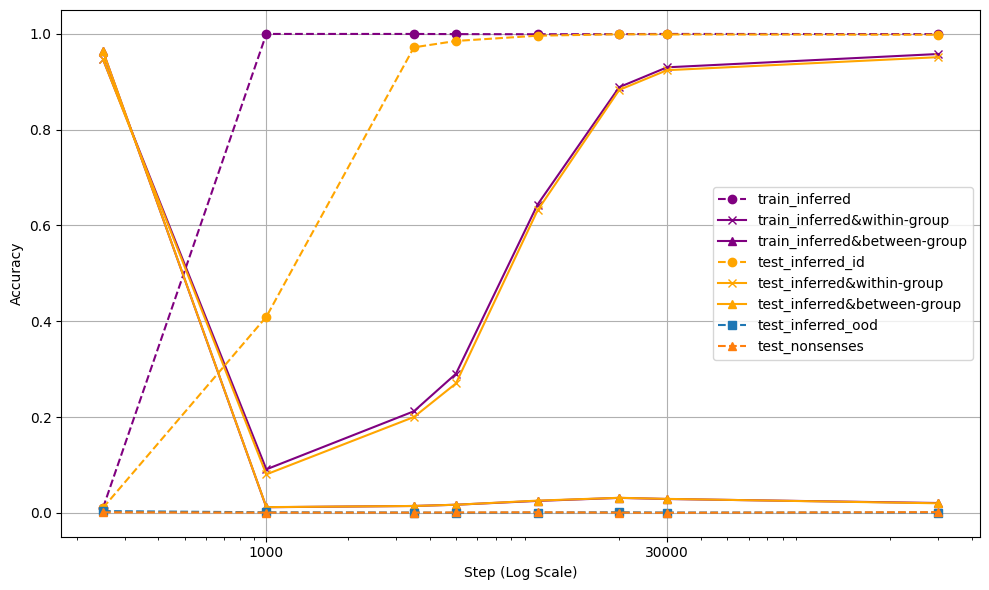

In [47]:
import matplotlib.pyplot as plt

# Plotting the accuracy values in the same plot
plt.figure(figsize=(10, 6))
x_values = [int(step) for step in all_steps]

# Plot each list with different markers and labels
plt.plot(x_values, all_acc["train_inferred"], label="train_inferred", color="purple", linestyle='--', marker='o')
plt.plot(x_values, result_dict["train_inferred"]["within-group"], label="train_inferred&within-group", color="purple", linestyle='-', marker='x')
plt.plot(x_values, result_dict["train_inferred"]["between-group"], label="train_inferred&between-group", color="purple", linestyle='-', marker='^')
plt.plot(x_values, all_acc["test_inferred_id"], label="test_inferred_id", linestyle='--', color="orange", marker='o')
plt.plot(x_values, result_dict["test_inferred_id"]["within-group"], label="test_inferred&within-group", color="orange", linestyle='-', marker='x')
plt.plot(x_values, result_dict["test_inferred_id"]["between-group"], label="test_inferred&between-group", color="orange", linestyle='-', marker='^')
plt.plot(x_values, all_acc["test_inferred_ood"], label="test_inferred_ood", linestyle='--', marker='s')
plt.plot(x_values, all_acc["test_nonsenses"], label="test_nonsenses", linestyle='--', marker='^')

# Set x-axis to log scale and customize ticks
plt.xscale("log")
plt.xticks([1000, 30000], labels=[f"{int(tick)}" for tick in [1000, 30000]])

# Labeling the plot
plt.xlabel("Step (Log Scale)")
plt.ylabel("Accuracy")
plt.legend(loc="center right")
plt.grid(True)
plt.tight_layout()